# Raster Peristimulus Time Histogram (PSTH) Example
Import snippet and epoc data into Python using **read_block**  
Generate peristimulus raster and histogram plots over all trials using **epoc_filter**  
Good for stim-response experiments, such as optogenetic or electrical stimulation
## Housekeeping
Import critial libraries

In [1]:
%config InlineBackend.close_figures = False
%matplotlib inline

import numpy as np # fundamental package for scientific computing, handles arrays and math
import matplotlib.pyplot as plt # standard Python plotting library
from matplotlib.ticker import MaxNLocator # so we can force integer tick labels later

# import the primary functions from the tdt library only
from tdt import read_block, epoc_filter, download_demo_data

## Importing the Data
This example uses our [example data sets](https://www.tdt.com/files/examples/TDTExampleData.zip). To import your own data, replace BLOCK_PATH with the full path to your own data block.

In Synapse, you can find the block path in the database. Go to Menu > History. Find your block, then Right-Click > Copy path to clipboard.

In [2]:
download_demo_data()
BLOCK_PATH = 'data/Algernon-180308-130351'

demo data ready


Set up the varibles for the data you want to extract. We will extract channel 1 from the eNe1 snippet data store, created by the PCA Sorting gizmo, and use our PulseGen epoc event `PC0/` as our stimulus onset.

In [3]:
REF_EPOC = 'PC0/'
SNIP_STORE = 'eNe1'
SORTID = 'TankSort'
CHANNEL = 3
SORTCODE = 0          # set to 0 to use all sorts
TRANGE = [-0.3, 0.8]

Now read the specified data from our block into a Python structure. The `nodata` flag means that we are only intereseted in the snippet timestamps, not the actual snippet waveforms in this example.

In [4]:
data = read_block(BLOCK_PATH, evtype=['epocs', 'snips', 'scalars'], sortname=SORTID, channel=CHANNEL, nodata=1)

read from t=0s to t=61.23s


## Use epoc_filter to extract data around our epoc event
Using the `t` parameter extracts data only from the time range around our epoc event.

In [5]:
raster_data = epoc_filter(data, REF_EPOC, t=TRANGE)

Adding the `tref` flag makes all of the timestamps relative to the epoc event, which is ideal for generating histograms.

In [6]:
hist_data = epoc_filter(data, REF_EPOC, t=TRANGE, tref=1)

And that's it! Your data is now in Python. The rest of the code is a simple plotting example. First, we'll find matching timestamps for our selected sort code (unit).

In [7]:
ts = raster_data.snips[SNIP_STORE].ts
if SORTCODE != 0:
    i = np.where(raster_data.snips[SNIP_STORE].sortcode == SORTCODE)[0]
    ts = ts[i]
if len(ts) == 0:
    raise Exception('no matching timestamps found')

num_trials = raster_data.time_ranges.shape[1]

## Make the histogram plot

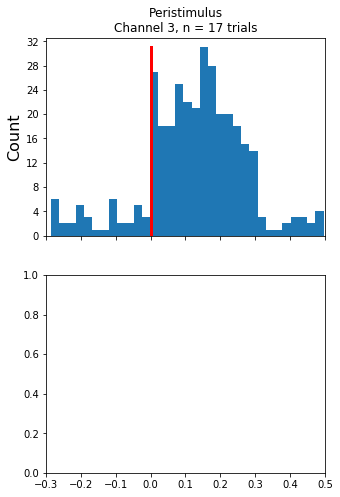

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))

hist_ts = hist_data.snips[SNIP_STORE].ts
nbins = np.int64(np.floor(len(hist_ts)/10.))
hist_n = ax1.hist(hist_ts, nbins)[0]

ax1.axis('tight')
ax1.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax1.set_ylabel('Count',fontsize=16)
ax1.set_title('Peristimulus\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

# Draw a vertical line at t=0.
ax1.plot([0, 0], [0, np.max(hist_n)], 'r-', linewidth=3)
plt.show()

## Creating the Raster Plot

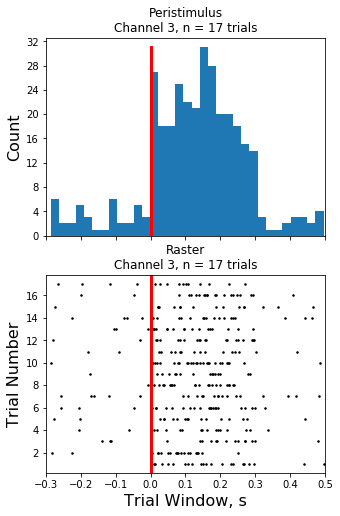

In [9]:
# For the raster plot, make an array of lists containing timestamps for each trial.
all_ts = [[] for x in range(num_trials)]
all_y = [[] for x in range(num_trials)]
for trial in range(num_trials):
    trial_on = raster_data.time_ranges[0, trial]
    trial_off = raster_data.time_ranges[1, trial]
    ind1 = ts >= trial_on
    ind2 = ts < trial_off
    trial_ts = ts[ind1 & ind2]
    all_ts[trial] = trial_ts - trial_on + TRANGE[0]
    all_y[trial] = (trial+1) * np.ones(len(trial_ts))

all_x = np.concatenate(all_ts)
all_y = np.concatenate(all_y)

# Make the raster plot.
ax2.plot(all_x, all_y, 'k.', markersize=3)
ax2.axis('tight')
ax2.set_xlim(left=TRANGE[0], right=TRANGE[0]+TRANGE[1])
ax2.set_xlabel('Trial Window, s',fontsize=16)
ax2.set_ylabel('Trial Number',fontsize=16)
ax2.set_title('Raster\nChannel {0}, n = {1} trials'.format(CHANNEL, num_trials))

# Draw a vertical line at t=0.
ax2.plot([0, 0], [0, trial+2], 'r-', linewidth=3)

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()